In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from tqdm import trange
import gc
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [0]:
start_token = "_"
eos = '#'
MAX_LENGTH = 40

In [0]:
data_pairs = pd.read_csv("drive/diploma/base_pairs.csv", index_col=0)
data_pairs.loc[:,"word_form"] = data_pairs.word_form.apply(lambda x: start_token + x + eos)
data_pairs.loc[:,"word_norm"] = data_pairs.word_norm.apply(lambda x: start_token + x + eos)
data_pairs.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,lex_id,word_norm,word_form,morph_features_form,morph_features_norm
0,1,_ёж#,_ежа#,"NOUN,anim,masc sing,gent","NOUN,anim,masc sing,nomn"
1,1,_ёж#,_ежу#,"NOUN,anim,masc sing,datv","NOUN,anim,masc sing,nomn"
2,1,_ёж#,_ежа#,"NOUN,anim,masc sing,accs","NOUN,anim,masc sing,nomn"
3,1,_ёж#,_ежом#,"NOUN,anim,masc sing,ablt","NOUN,anim,masc sing,nomn"
4,1,_ёж#,_еже#,"NOUN,anim,masc sing,loct","NOUN,anim,masc sing,nomn"


In [0]:
s = "".join(data_pairs.word_form)
tokens = np.sort(np.array(list(set(s))))
    
tok2id = dict(zip(tokens, np.arange(tokens.shape[0])))
id2tok = dict(zip(np.arange(tokens.shape[0]), tokens))

print ('There are {} tokens',len(tokens))

print('Vocabular: ' + "".join(tokens))

# np.save('drive/diploma/vocabulary/tok2id.npy', tok2id) 

# np.save('drive/diploma/vocabulary/id2tok.npy', id2tok) 

There are {} tokens 48
Vocabular: #'-0123456789_абвгдежзийклмнопрстуфхцчшщъыьэюяё’


In [0]:
import re
# s_f = np.hstack(data_pairs.morph_features_form.apply(lambda x: re.split(",| ", x)).values)
# tokens_f = np.sort(np.array(list(set(s_f))))

set_morph = set()
for i in range(data_pairs.shape[0]):
  loc = re.split(",| ", data_pairs.morph_features_form.values[i])
  for elem in loc:
    set_morph.add(elem)
tokens_f = np.sort(np.array(list(set_morph)))

tok2id_f = dict(zip(tokens_f, np.arange(tokens_f.shape[0])))
# id2tok_f = dict(zip(np.arange(tokens.shape[0]), tokens))

# np.save('drive/diploma/vocabulary/tok2id_f.npy', tok2id_f) 

print ('There are {} tokens',len(tokens_f))

print('Vocabular: ' + "".join(tokens_f))

There are {} tokens 100
Vocabular: 1per2per3perADJFADJSADVBAbbrAdjxAf-pAnphAnumAproArchCOMPCONJCmp2CollCounDistDmnsErroFimpFixdGNdrGRNDGeoxHypoINFNINTJImpeImpxInfrInitInmxLitrMs-fNOUNNPRONUMRNameOrgnPRCLPREDPREPPRTFPRTSPatrPltmPossPrdxPrntQualQuesSgtmSlngSubxSuprSurnV-beV-biV-ejV-enV-eyV-ieV-oyV-shVERBVpreabltaccsactvanimdatvexclfemnfutrgen1gen2gentimpfimprinaninclindcintrloc1loc2loctmascms-fneutnomnpastperfplurprespssvsingtranvoct


In [0]:
SOS_token = tok2id[start_token]
EOS_token = tok2id[eos]

In [0]:
def to_matrix(words, max_len=None, pad=tok2id[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [0]:
tok2id_f[eos] = 100

def to_matrix_f(words, max_len=None, pad=tok2id_f[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id_f.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [0]:
# Creating training and validation sets using an 80-20 split

indices = data_pairs.lex_id.unique()
np.random.seed(42)
np.random.shuffle(indices)
data_pairs.set_index("lex_id", inplace=True)
train = data_pairs.loc[indices[:int(0.8 * indices.shape[0])]]
input_train = train.drop("word_form", axis=1)
target_train = train.word_form.values

test = data_pairs.loc[indices[int(0.8 * indices.shape[0]):]]
input_test = test.drop("word_form", axis=1)
target_test = test.word_form.values

In [0]:
class pairs_Dataset(Dataset):
    def __init__(self, data, data_form):
        self.data = data
        self.target = data_form
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.data.word_norm.values[index], self.data.morph_features_form.values[index], self.target[index], self.data.morph_features_norm.values[index]

In [0]:
BATCH_SIZE = 512

train_data = pairs_Dataset(input_train, target_train)

dataset = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

test_data = pairs_Dataset(input_test, target_test)

test_batches = DataLoader(test_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = BATCH_SIZE
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, morph_feat_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.morph_size = morph_feat_size
        self.batch_size = BATCH_SIZE
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.emb_morph = nn.Embedding(self.morph_size, self.hidden_size // 16)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(688 // 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, morph_feat, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs)
        
        embedded_feat = self.emb_morph(morph_feat).view(1, self.batch_size, -1)
        
        output = torch.cat((embedded[0], attn_applied.squeeze(), embedded_feat[0]), 1)

        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [0]:
teacher_forcing_ratio = 0.5

def train_batch(X, X_f, y, encoder, decoder, encoder_opt, decoder_opt, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    max_length = X.shape[1]
    encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
    loss = 0
    for i in range(X.shape[1]):
        encoder_output, encoder_hidden = encoder(
            X[:, i], encoder_hidden)
        encoder_outputs[:, i] = encoder_output[0]

    decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, X_f, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, y[:, di])
            decoder_input = y[:, di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, X_f, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, y[:, di])
    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 0.5)
    encoder_opt.step()
    decoder_opt.step()

    return loss.item()

In [0]:
def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    plt.xlabel('train steps')
    plt.grid()
    plt.show()
    
    
def test(encoder, decoder, criterion, test_batches, loss_log, acc_log):
    encoder.eval()
    decoder.eval()
    for batch_num, batch in zip(trange(len(test_batches)), test_batches):
        encoder_hidden = encoder.initHidden()
        max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
        X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
        X_f = torch.from_numpy(to_matrix_f(np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))]), max_len=11)).to(device)
        y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)
        max_length = X.shape[1]
        encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
        loss = 0
        acc = 0
        for i in range(X.shape[1]):
            encoder_output, encoder_hidden = encoder(
                X[:, i], encoder_hidden)
            encoder_outputs[:, i] = encoder_output[0]

        decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)
        gc.collect()
        decoder_hidden = encoder_hidden
        decoder_pred = []
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, X_f, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, y[:, di])
            decoder_pred.append(decoder_input.cpu())
        res = np.vstack(decoder_pred).T
        pred_res = ["".join(id2tok[_] for _ in res[i]) for i in range(res.shape[0])]
        true_res = ["".join(id2tok[_] for _ in y.cpu().numpy()[i]) for i in range(y.shape[0])]
        acc = accuracy_score(pred_res, true_res)
            
        loss_log.append(float(loss) / X.shape[0])
        acc_log.append(acc)

    plot_history(loss_log, title="Test")
    plot_history(acc_log, title="Accuracy")
    print("Mean accuracy - {}".format(np.mean(acc_log)))
    return loss_log

def train(data, test_batches, encoder, decoder, encoder_optimizer, decoder_optimizer,  n_epochs, print_every=1, plot_every=1, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    loss_log = []
    acc_log = []

    
    criterion = nn.NLLLoss()

    for epoch in range(n_epochs):
        encoder.train()
        decoder.train()
        loss = 0
        for batch_num, batch in zip(trange(len(data)), data):
            max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
            X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
            X_f = torch.from_numpy(to_matrix_f(np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))]), max_len=11)).to(device)
            y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)
            loss = train_batch(X, X_f, y, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
            plot_losses.append(float(loss) / X.shape[0])
        
        clear_output()
        gc.collect()
        print("Loss - {}".format(loss))
        print("Epoch - {}".format(epoch))
        plot_history(plot_losses, "Train")
        torch.save({
            'encoder1_state_dict': encoder.state_dict(),
            'attn_decoder1_state_dict': decoder.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': decoder_optimizer.state_dict()
            }, "drive/diploma/simple_seq2seq/unidir_GRU_{}".format(epoch))
    gc.collect()
    test(encoder, decoder, criterion, test_batches, loss_log, acc_log)
        

In [0]:
hidden_size = 128
learning_rate=0.01
encoder1 = EncoderRNN(tokens.shape[0], hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, tokens.shape[0], tokens_f.shape[0] + 1, dropout_p=0.1).to(device)
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(attn_decoder1.parameters(), lr=learning_rate)

Loss - 18.906660079956055
Epoch - 2


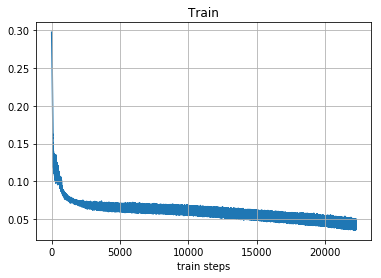

 23%|██▎       | 1724/7422 [04:14<14:02,  6.76it/s]

In [0]:

train(dataset, test_batches, encoder1, attn_decoder1, encoder_optimizer, decoder_optimizer, 20)

100%|██████████| 1860/1860 [05:49<00:00,  5.42it/s]


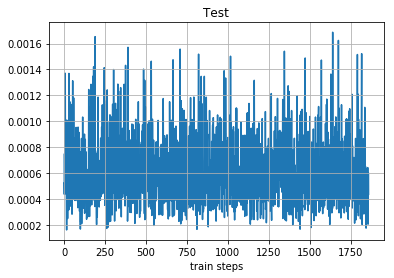

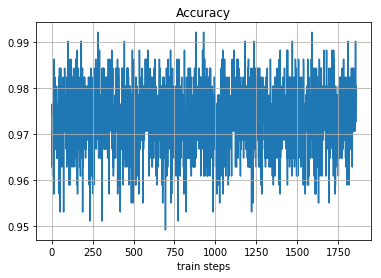

Mean accuracy - 0.9734574512768818


[0.0005224571214057505,
 0.00043536367593333125,
 0.0007488646078854799,
 0.0005244146450422704,
 0.0005075055523775518,
 0.00043775298399850726,
 0.0013709054328501225,
 0.0011834113392978907,
 0.00045527928159572184,
 0.0008426159620285034,
 0.0006906556664034724,
 0.0008184617618098855,
 0.0005251388065516949,
 0.0005898296949453652,
 0.0003805111045949161,
 0.00015991140389814973,
 0.0010092005832120776,
 0.0006187847466208041,
 0.0004401255864650011,
 0.0005981128197163343,
 0.0007961681112647057,
 0.00024791734176687896,
 0.0006599303451366723,
 0.0003529425011947751,
 0.0006743920966982841,
 0.0006275314372032881,
 0.0006697735516354442,
 0.00085181969916448,
 0.00031471496913582087,
 0.0013693490764126182,
 0.0003823108272626996,
 0.0005165158654563129,
 0.0006657548947259784,
 0.0007180628599599004,
 0.001151045085862279,
 0.0005804297397844493,
 0.000521377194672823,
 0.000510440906509757,
 0.0006648647249676287,
 0.000848021823912859,
 0.0006227933918125927,
 0.0006408460903

In [0]:
# 31 эпоха
loss_log = []
acc_log = []
criterion = nn.NLLLoss()
test(encoder1, attn_decoder1, criterion, test_batches, loss_log, acc_log)

100%|██████████| 1860/1860 [06:03<00:00,  4.86it/s]


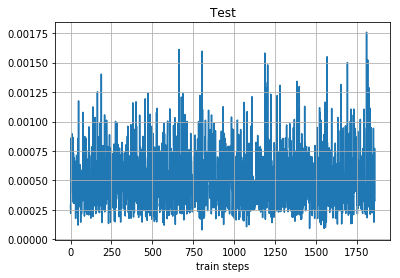

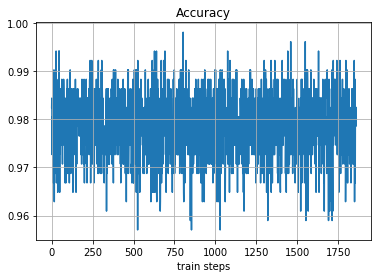

Mean accuracy - 0.9787077872983871


[0.0002883298438973725,
 0.00022152019664645195,
 0.0007791005773469806,
 0.0008600078872404993,
 0.0006301255198195577,
 0.0005214362172409892,
 0.00041383743518963456,
 0.00040061393519863486,
 0.0006113182753324509,
 0.0008967895992100239,
 0.000721064570825547,
 0.0004853643476963043,
 0.0006763208075426519,
 0.0008681771578267217,
 0.0005580190336331725,
 0.0003904786426573992,
 0.0008591345394961536,
 0.000314544711727649,
 0.0007296261610463262,
 0.00030700908973813057,
 0.00032705580815672874,
 0.0004775411216542125,
 0.000305169727653265,
 0.0006908282521180809,
 0.0003858775307890028,
 0.0006669595022685826,
 0.0005258985911495984,
 0.00041579603566788137,
 0.00041013507870957255,
 0.0006495900452136993,
 0.0004757613642141223,
 0.00017796302563510835,
 0.0003101667680311948,
 0.00027193158166483045,
 0.00025854058912955225,
 0.000396976072806865,
 0.0005866056890226901,
 0.0007133267354220152,
 0.00045959249837324023,
 0.00022920937044546008,
 0.0003223902022000402,
 0.00056

In [0]:
# 41 эпоха
loss_log = []
acc_log = []
criterion = nn.NLLLoss()
test(encoder1, attn_decoder1, criterion, test_batches, loss_log, acc_log)

In [0]:
torch.save({
            'encoder1_state_dict': encoder1.state_dict(),
            'attn_decoder1_state_dict': attn_decoder1.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': decoder_optimizer.state_dict()
            }, "drive/diploma/simple_seq2seq/final_41_epoch")

In [0]:
checkpoint = torch.load("drive/diploma/simple_seq2seq/unidir_GRU_6")
encoder1.load_state_dict(checkpoint['encoder1_state_dict'])
encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])

attn_decoder1.load_state_dict(checkpoint['attn_decoder1_state_dict'])
decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])

In [0]:
!pip install pymorphy2

100%|██████████| 3721/3721 [06:31<00:00,  9.68it/s]


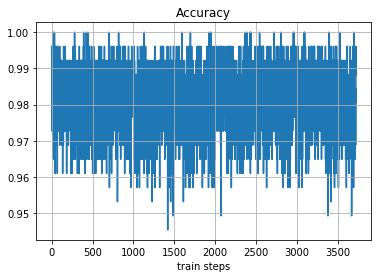

Mean accuracy - 0.9812938810131685


In [0]:

import pymorphy2

acc_log = []
morph = pymorphy2.MorphAnalyzer()
t = 0
for batch_num, batch in zip(trange(len(test_batches)), test_batches):
  X = batch[0]
  X_f = np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))])
  y = batch[2]
  norm_form = np.array([re.split(",| ", batch[3][i]) for i in range(len(batch[1]))])
  acc = 0
  neg_acc = 0
  for i in range(len(X)):
    py_lemmas = morph.parse(X[i][1:-1])
    morph_set = set(X_f[i])
    py_lemma = 0
    if "ms-f" in norm_form[i]:
      for j, elem in enumerate(norm_form[i]):
        if elem == "ms-f":
          norm_form[i][j] = "Ms-f"
    for p_lem in py_lemmas:
      if set(norm_form[i]) in p_lem.tag:
        py_lemma = p_lem
    try: 
      pred = py_lemma.inflect(morph_set).word
    except:
      t += 1
      
    acc += pred == y[i][1:-1]
    neg_acc += pred != y[i][1:-1]
  acc_log.append(acc / (acc + neg_acc))
plot_history(acc_log, title="Accuracy")
print("Mean accuracy - {}".format(np.mean(acc_log)))